# Notes
* metrics for recommendation comparison
* get tags encoded
* scrape/dataset for other info
* markdown(more descriptive)
* remove last user rating, predict if you get the same movie

# import libraries

In [1]:
# for dataframe building
import pandas as pd
import numpy as np
from surprise import Dataset, Reader

# Importing models that I want to run
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.baseline_only import BaselineOnly

# KNN Based Models
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline

# Matrix Factorization Based Models
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp, NMF

# Will help measure how our models do
from surprise.model_selection import cross_validate

# import data

In [2]:
links = pd.read_csv('Data/links.csv')
tags = pd.read_csv('Data/tags.csv')
ratings = pd.read_csv('Data/ratings.csv')
movies = pd.read_csv('Data/movies.csv')

In [3]:
movies.shape

(9742, 3)

In [4]:
tags.shape

(3683, 4)

In [5]:
links.shape

(9742, 3)

In [6]:
ratings.shape

(100836, 4)

# merge data into one dataframe

merge ratings and movie info

In [7]:
df = pd.merge(ratings, movies, left_on='movieId', right_on='movieId', how='left')

merge previous set with links

In [8]:
df = pd.merge(df, links, left_on = 'movieId', right_on='movieId', how='left')

#### Merging tags together
* It will appear similar to the genre entry

In [9]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


* get a user
* get a movie the user has seen
* get a list of all the tags for this movie
* repeat for all movies
* repeat for all movies
* match up tags by user and movie

In [10]:
temp_movie = tags[tags.userId==2]

In [11]:
my_tags = []
for t in temp_movie[temp_movie.movieId==60756].tag:
    my_tags.append(t)
my_tags

['funny', 'Highly quotable', 'will ferrell']

In [12]:
tags.userId.value_counts()

474    1507
567     432
62      370
599     323
477     280
424     273
537     100
125      48
357      45
318      41
184      35
573      31
193      20
18       16
119      14
336      10
2         9
305       8
606       7
327       7
166       6
419       5
356       5
462       5
103       5
132       4
291       4
21        4
435       4
289       4
226       3
205       3
509       3
487       3
319       3
439       3
177       3
49        3
506       3
112       3
610       3
533       3
513       3
106       2
76        2
138       2
63        2
256       2
341       2
520       2
274       1
288       1
167       1
600       1
161       1
7         1
543       1
300       1
Name: userId, dtype: int64

In [190]:
tags[tags.userId==442]

,userId,movieId,tag,timestamp


In [199]:
df['tags'] = ''

In [200]:
df

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tags
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,113277,949.0,
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,114369,807.0,
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,114814,629.0,
...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller,4972582,381288.0,
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller,4425200,324552.0,
100833,610,168250,5.0,1494273047,Get Out (2017),Horror,5052448,419430.0,
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,3315342,263115.0,


In [327]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [345]:
iter_test = df.iloc[:10]

In [346]:
iter_test

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tags
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,113277,949.0,
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,114369,807.0,
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,114814,629.0,
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller,116367,755.0,
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance,115734,13685.0,
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War,112573,197.0,
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War,114287,11780.0,
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War,109370,1775.0,


In [352]:
for i, entry in df.iterrows():
    current_user = entry.userId
    current_movie = entry.movieId
    current_tags = tags[(tags.userId==current_user)&(tags.movieId==current_movie)].tag
    entry.tags = current_tags

In [354]:
df[(df.userId==2)&(df.movieId==60756)]

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tags
241,2,60756,5.0,1445714980,Step Brothers (2008),Comedy,838283,12133.0,


In [350]:
iter_test

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tags
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,113277,949.0,
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,114369,807.0,
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,114814,629.0,
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller,116367,755.0,
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance,115734,13685.0,
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War,112573,197.0,
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War,114287,11780.0,
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War,109370,1775.0,


In [326]:
#users = df.userId.unique()
users = [506]

def get_tags(df):
    all_tags = []
    for i, entry in df.iterrows():
        user = entry.userId
        movie = entry.movieId
        movie_user_tags = {}
        user_info = tags[tags.userId == user]
        user_info = user_info[user_info.movieId == movie]
        user_tags = []
        for tag in user_info:
            user_tags.append(tag)
        all_tags.append(user_tags)
    return all_tags

#     for user in users:
#         user_info = tags[tags.userId==user]
#         print(user_info)
#         user_movies = user_info.movieId.unique()
#         print(user_movies)
#         for movie in user_movies:
#             user_tags = []
#             for tag in user_info[user_info.movieId==movie].tag:
#                 user_tags.append(tag)
#             movie_user_tags[str(movie)] = user_tags
    
all_tags = get_tags(tags)

AttributeError: ("'Series' object has no attribute 'iterrows'", 'occurred at index 0')

In [204]:
df.tags.isnull().value_counts()

False    100836
Name: tags, dtype: int64

In [184]:
movie_user_tags

{}

In [174]:
users = df.userId.unique()
user_movie_tags = []
for user in users:
    m_tags = []
    temp_user_df = tags[tags['userId']==user]
    for m in tags['movieId']:
        temp_m_df = temp_user_df[temp_user_df['movieId']==m]
        for t in temp_m_df.tag:
            m_tags.append(t)
    print(m_tags)



[]
['funny', 'Highly quotable', 'will ferrell', 'funny', 'Highly quotable', 'will ferrell', 'funny', 'Highly quotable', 'will ferrell', 'Boxing story', 'MMA', 'Tom Hardy', 'Boxing story', 'MMA', 'Tom Hardy', 'Boxing story', 'MMA', 'Tom Hardy', 'drugs', 'Leonardo DiCaprio', 'Martin Scorsese', 'drugs', 'Leonardo DiCaprio', 'Martin Scorsese', 'drugs', 'Leonardo DiCaprio', 'Martin Scorsese', 'funny', 'Highly quotable', 'will ferrell', 'funny', 'Highly quotable', 'will ferrell', 'funny', 'Highly quotable', 'will ferrell', 'funny', 'Highly quotable', 'will ferrell', 'funny', 'Highly quotable', 'will ferrell', 'drugs', 'Leonardo DiCaprio', 'Martin Scorsese', 'drugs', 'Leonardo DiCaprio', 'Martin Scorsese']
[]
[]
[]
[]
['way too long', 'way too long', 'way too long', 'way too long', 'way too long', 'way too long', 'way too long', 'way too long', 'way too long', 'way too long']
[]


KeyboardInterrupt: 

In [68]:
import matplotlib.pyplot as plt

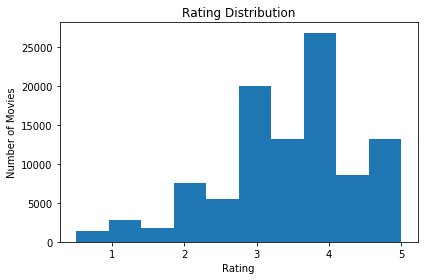

In [71]:
plt.hist(temp.rating)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.savefig('ratingdist.png')

In [89]:
years = []
for title in df.title:
    years.append(title[-5:-1])

In [94]:
cleaned_years = []
for year in years:
    try:
        cleaned_years.append(int(year))
    except:
        continue

In [97]:
max(cleaned_years)

2018

In [98]:
min(cleaned_years)

1902

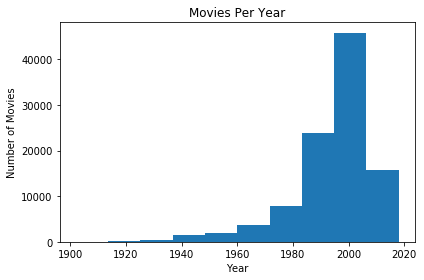

In [100]:
plt.hist(cleaned_years)
plt.title('Movies Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.savefig('movieyear.png')

In [74]:
sorted(dict(temp.rating.value_counts(normalize=True)), key=lambda x: x[1], reverse=True)

TypeError: 'float' object is not subscriptable

# turn genres into a list
I'm doing this to separate each genre as their own object instead of all of them being together into one string

In [13]:
def genre_list(entry):
    return entry.split('|')

In [14]:
df.genres = df.genres.apply(genre_list)

In [17]:
df

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",114709,862.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]",113228,15602.0
2,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]",113277,949.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",114369,807.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",114814,629.0
...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),"[Drama, Horror, Thriller]",4972582,381288.0
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),"[Action, Crime, Thriller]",4425200,324552.0
100833,610,168250,5.0,1494273047,Get Out (2017),[Horror],5052448,419430.0
100834,610,168252,5.0,1493846352,Logan (2017),"[Action, Sci-Fi]",3315342,263115.0


In [18]:
pd.get_dummies(df.iloc[:,5])

TypeError: unhashable type: 'list'

# *look into the recommendation outputs*
different cases:
1. new user
2. few inputs
3. rating movies they know

# Going Through Models
running models and comparing one another as is

#### Making an instance of each model

In [11]:
temp = df[['userId', 'movieId', 'rating']]

In [12]:
norm_pred = NormalPredictor()
baseline = BaselineOnly()

In [13]:
knn_basic = KNNBasic()
knn_means = KNNWithMeans()
knn_z = KNNWithZScore()
knn_baseline = KNNBaseline()

In [14]:
svd = SVD()
svd_pp = SVDpp()
nmf = NMF()

In [26]:
reader=Reader()

In [27]:
data = Dataset.load_from_df(temp, reader)

##### This will run the data through each model and calculate the average rmse and mae. It will append the scores list with the name of the algorithm, the average rmse, and the average mae


In [28]:
algs = [norm_pred, baseline, knn_basic, knn_means, knn_z, knn_baseline, svd, svd_pp, nmf]
algs_name = ['Normal Predictor', 'Baseline Only', 'KNN Basic', 'KNN with Means', 'KNN with Z-score', 'KNN Baseline', 'SVD', 'SVD pp', 'NMF']
scores = []
for a in algs:
    output = cross_validate(a, data, n_jobs=-1)
    rmse = np.mean(output['test_rmse'])
    mae = np.mean(output['test_mae'])
    scores.append([algs_name[algs.index(a)], rmse, mae])

##### Checking the scores

In [29]:
scores

[['Normal Predictor', 1.4209823560344021, 1.136240213827516],
 ['Baseline Only', 0.8723150333415297, 0.6727195213071893],
 ['KNN Basic', 0.9467127292646836, 0.7255754499447289],
 ['KNN with Means', 0.8967080975019084, 0.685089393964404],
 ['KNN with Z-score', 0.8949173250799852, 0.6792276509636517],
 ['KNN Baseline', 0.8746749171649915, 0.6685877587864708],
 ['SVD', 0.8733301312080014, 0.6714992640801067],
 ['SVD pp', 0.861051286967301, 0.6599587285506395],
 ['NMF', 0.919784577110572, 0.7048225227653481]]

# SVDpp did the best, so we continue to build our recommendation system with this model

In [30]:
from surprise import Reader, Dataset

Make our data usable for our model

In [31]:
reader = Reader()

temp is our df in a [userid, movieid, rating] format so we can use a Dataset class
to load our data

In [32]:
data = Dataset.load_from_df(temp, reader)

#### Picking a random user and looking at their movie selections

In [33]:
user = np.random.choice(df.userId)
print(user)

41


In [34]:
user_ratings = df[df.userId == user]
user_ratings = user_ratings[['userId', 'movieId', 'rating']]

In [35]:
user_ratings

,userId,movieId,rating
5658,41,47,3.5
5659,41,50,3.0
5660,41,111,2.0
5661,41,215,2.0
5662,41,288,3.0
...,...,...,...
5870,41,136864,0.5
5871,41,138036,2.0
5872,41,139385,4.0
5873,41,140110,3.5


In [36]:
for m in user_ratings.sort_values('rating',ascending=False).movieId[:10]:
    print(movies[movies['movieId']==m].title)

4867    50 First Dates (2004)
Name: title, dtype: object
3006    Cast Away (2000)
Name: title, dtype: object
957    Shining, The (1980)
Name: title, dtype: object
958    Stand by Me (1986)
Name: title, dtype: object
8255    Prisoners (2013)
Name: title, dtype: object
7638    Horrible Bosses (2011)
Name: title, dtype: object
1291    Titanic (1997)
Name: title, dtype: object
1616    Rosemary's Baby (1968)
Name: title, dtype: object
4814    Along Came Polly (2004)
Name: title, dtype: object
2036    Eyes Wide Shut (1999)
Name: title, dtype: object


In [59]:
for m in user_ratings.movieId[0:10]:
    print(movies[movies.movieId==m].title, movies[movies.movieId==m].genres)

43    Seven (a.k.a. Se7en) (1995)
Name: title, dtype: object 43    Mystery|Thriller
Name: genres, dtype: object
46    Usual Suspects, The (1995)
Name: title, dtype: object 46    Crime|Mystery|Thriller
Name: genres, dtype: object
98    Taxi Driver (1976)
Name: title, dtype: object 98    Crime|Drama|Thriller
Name: genres, dtype: object
183    Before Sunrise (1995)
Name: title, dtype: object 183    Drama|Romance
Name: genres, dtype: object
249    Natural Born Killers (1994)
Name: title, dtype: object 249    Action|Crime|Thriller
Name: genres, dtype: object
254    Léon: The Professional (a.k.a. The Professiona...
Name: title, dtype: object 254    Action|Crime|Drama|Thriller
Name: genres, dtype: object
257    Pulp Fiction (1994)
Name: title, dtype: object 257    Comedy|Crime|Drama|Thriller
Name: genres, dtype: object
314    Forrest Gump (1994)
Name: title, dtype: object 314    Comedy|Drama|Romance|War
Name: genres, dtype: object
315    Four Weddings and a Funeral (1994)
Name: title, dtype: 

#### Using SVDpp to make predictions

In [38]:
svd_pp = SVDpp(n_factors=50, reg_all=0.05)

Making a train set and test set. Then we fit our model to our train set

In [39]:
train_set = data.build_full_trainset()

In [40]:
svd_pp.fit(train_set)

In [41]:
test_set = train_set.build_anti_testset()
predictions = svd_pp.test(test_set)

In [42]:
from surprise.accuracy import rmse

In [43]:
rmse(predictions)

RMSE: 0.4991


0.4990659860919711

In [102]:
train_preds = svd_pp.

TypeError: 'Trainset' object is not iterable

In [44]:
svd_pp.predict(user, 110)

Prediction(uid=41, iid=110, r_ui=None, est=3.49542198639712, details={'was_impossible': False})

In [45]:
temp

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [61]:
def get_movie_recs(movies,user, n_recs):
    '''
    Returns the top n recommendations for movies.
    
    movies: The dataframe with the movie ID numbers and titles.
    
    user: User ID number
    
    n_recs: The number of recommendations to return
    '''
    movie_list = []
    for movie in temp['movieId'].unique():
        movie_list.append((movie,svd_pp.predict(user,movie)[3]))

    ranked_movie_list = sorted(movie_list, key=lambda x:x[1], reverse=True)
    recommendations = []
    for m in ranked_movie_list[0:10]:
        recommendations.append([movies[movies.movieId==m[0]].title, movies[movies.movieId==m[0]].genres])
    print(user)
    return recommendations

In [62]:
get_movie_recs(movies, user, 10)

41


[[8575    Wild Tales (2014)
  Name: title, dtype: object, 8575    Comedy|Drama|Thriller
  Name: genres, dtype: object], [681    Singin' in the Rain (1952)
  Name: title, dtype: object, 681    Comedy|Musical|Romance
  Name: genres, dtype: object], [906    Lawrence of Arabia (1962)
  Name: title, dtype: object, 906    Adventure|Drama|War
  Name: genres, dtype: object], [1616    Rosemary's Baby (1968)
  Name: title, dtype: object, 1616    Drama|Horror|Thriller
  Name: genres, dtype: object], [2593    Hustler, The (1961)
  Name: title, dtype: object, 2593    Drama
  Name: genres, dtype: object], [929    Raging Bull (1980)
  Name: title, dtype: object, 929    Drama
  Name: genres, dtype: object], [924    Grand Day Out with Wallace and Gromit, A (1989)
  Name: title, dtype: object,
  924    Adventure|Animation|Children|Comedy|Sci-Fi
  Name: genres, dtype: object], [913    Third Man, The (1949)
  Name: title, dtype: object, 913    Film-Noir|Mystery|Thriller
  Name: genres, dtype: object], [17

In [48]:
from surprise.model_selection import GridSearchCV

In [49]:
param_grid = {'n_factors':[10,20,50],
              'n_epochs':[20,40],
              'init_std_dev':[.1,.15]}

In [57]:
gs_svdpp = GridSearchCV(SVDpp,param_grid=param_grid,cv=3)

In [103]:
gs_svdpp.fit(data)

KeyboardInterrupt: 

In [ ]:
print(gs_svdpp.best_score['rmse'])

In [ ]:
print(gs_svdpp.best_params['rmse'])